# Creating and Backtesting Mean-Reversion Strategies (Bollinger Bands)

## Getting the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")

In [3]:
data

,price
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2018-01-01 22:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2070 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


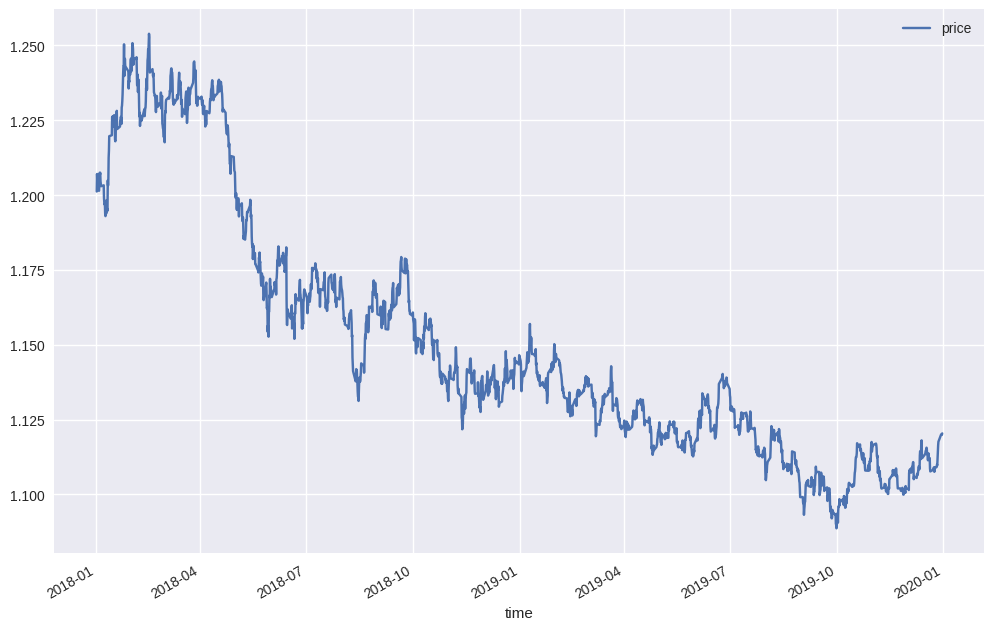

In [5]:
data.plot(figsize = (12, 8))
plt.show()

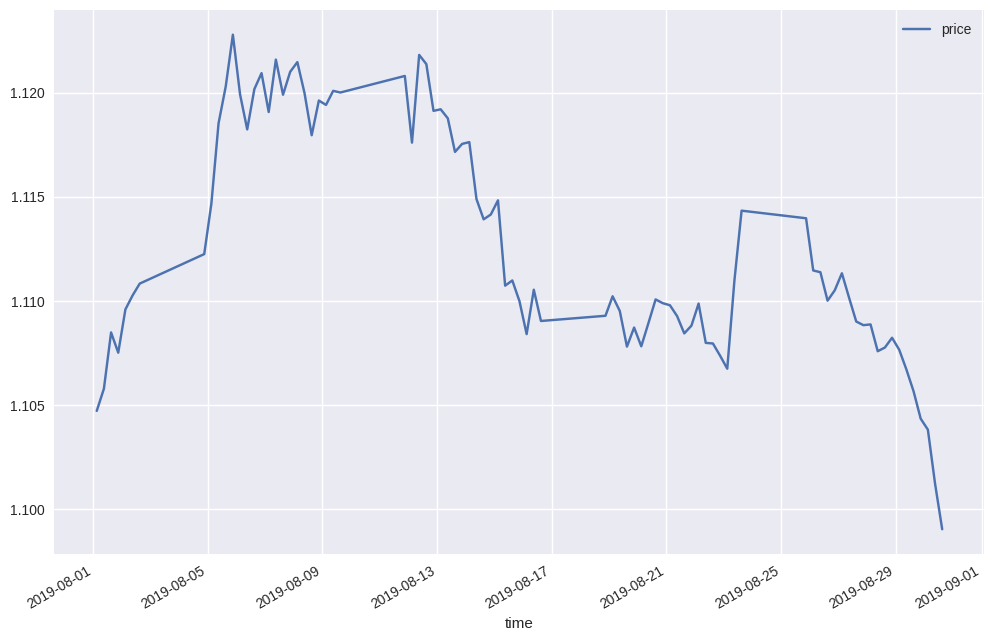

In [6]:
data.loc["2019-08"].plot(figsize = (12, 8))
plt.show()

In [7]:
data["returns"] = np.log(data.div(data.shift(1)))

In [8]:
data

,price,returns
time,,
2018-01-01 22:00:00+00:00,1.201205,NaN
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092
2019-12-30 04:00:00+00:00,1.119940,0.000018
2019-12-30 10:00:00+00:00,1.120095,0.000138


## Defining a Mean-Reversion Strategy (Bollinger Bands) (Part 1)

__Mean Reversion__: Financial Instruments are from time to time overbought / oversold and revert back to mean prices. 

__Bollinger Bands__: Consists of a SMA (e.g. 30) and Upper and Lower Bands +- (2) Std Dev away from SMA.

In [ ]:
SMA = 30
dev = 2

In [ ]:
data["SMA"] = data["price"].rolling(SMA).mean()

In [ ]:
data[["price", "SMA"]].plot(figsize = (12, 8))
plt.show()

In [ ]:
data.loc["2019-08", ["price", "SMA"]].plot(figsize = (12, 8))
plt.show()

In [ ]:
data["price"].rolling(SMA).std()

In [ ]:
data["price"].rolling(SMA).std().plot(figsize = (12, 8 ))
plt.show()

In [ ]:
data["Lower"] = data["SMA"] - data["price"].rolling(SMA).std() * dev # Lower Band -2 Std Dev

In [ ]:
data["Upper"] = data["SMA"] + data["price"].rolling(SMA).std() * dev # Upper Band -2 Std Dev

In [ ]:
data.drop(columns = "returns").plot(figsize = (12, 8))
plt.show()

In [ ]:
data.drop(columns = "returns").loc["2019-08"].plot(figsize = (12, 8))
plt.show()

In [ ]:
data.dropna(inplace = True)

## Defining a Mean-Reversion Strategy (Bollinger Bands) (Part 2)

In [ ]:
data

In [ ]:
data["distance"] = data.price - data.SMA # helper Column

In [ ]:
data["position"] = np.where(data.price < data.Lower, 1, np.nan) # 1. oversold -> go long

In [ ]:
data["position"] = np.where(data.price > data.Upper, -1, data["position"]) # 2. overbought -> go short

In [ ]:
data

In [ ]:
# 3. crossing SMA ("Middle Band") -> go neutral
data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])

In [ ]:
data

In [ ]:
data["position"] = data.position.ffill().fillna(0) # where 1-3 isn´t applicable -> hold previous position

In [ ]:
data.position.value_counts()

In [ ]:
data.drop(columns = ["returns", "distance"]).loc["2019-08"].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

In [ ]:
data.position.plot(figsize = (12, 8))
plt.show()

## Vectorized Strategy Backtesting

In [ ]:
data

In [ ]:
data["strategy"] = data.position.shift(1) * data["returns"]

In [ ]:
data.dropna(inplace = True)

In [ ]:
data

In [ ]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

In [ ]:
data[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

In [ ]:
data

In [ ]:
ptc = 0.00007

In [ ]:
data["trades"] = data.position.diff().fillna(0).abs()

In [ ]:
data

In [ ]:
data.trades.value_counts()

In [ ]:
data["strategy_net"] = data.strategy - data.trades * ptc

In [ ]:
data["cstrategy_net"] = data.strategy_net.cumsum().apply(np.exp)

In [ ]:
data

In [ ]:
data[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

In [ ]:
data[["returns", "strategy_net"]].mean() * (4 * 252) # annualized return

In [ ]:
data[["returns", "strategy_net"]].std() * np.sqrt(4 * 252) # annualized risk